# EECE5644 Summer 1 2022 - Assignment 1

Imports for notebook:

In [133]:
import matplotlib.pyplot as plt # For general plotting

import numpy as np

from scipy.stats import multivariate_normal # MVN not univariate
from sklearn.metrics import confusion_matrix

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

## Question 1 
### Part A



ERM classification for a two-class problem.

The pdf for X is p(x) = p(x|L=0)P(L=0) + p(x|L=1)P(L=1).

The class priors are respectively $P(L=0)=0.65$, $P(L=1)=0.35$

The class-conditional pdfs are:

p(x|L=0) = g(x|m0, C0)

p(x|L=1) = g(x|m1, C1)

where g() is multivariate gaussian pdf with parameters:

\begin{equation*}
\mathcal{N}(\begin{bmatrix}-1/2\\-1/2\\-1/2\end{bmatrix},\begin{bmatrix}1 & -0.5 & 0.3\\-0.5 & 1 & -0.5\\0.3 & -0.5 & 1\end{bmatrix}) 
\quad
\mathcal{N}(\begin{bmatrix}1\\1\\1\end{bmatrix},\begin{bmatrix}1 & 0.3 & -0.2\\0.3 & 1 &0.3\\-0.2 & 0.3 & 1\end{bmatrix})
\quad
\end{equation*}

Generate 10000 samples according to this data distribution, keep track of the true class labels for each sample. 

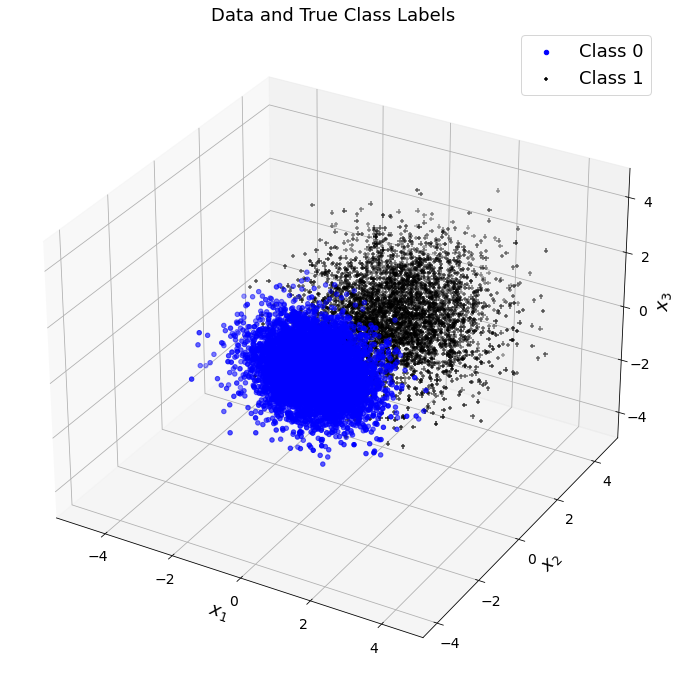

In [134]:
N = 10000

# Mean and covariance of data pdfs conditioned on labels
mu = np.array([[-0.5, -0.5, -0.5],
               [1, 1, 1]])  # Gaussian distributions means
Sigma = np.array([[[1, -0.5, 0.3],
                   [-0.5, 1, -0.5],
                   [0.3, -0.5, 1]],
                  [[1, 0.3, -0.2],
                   [0.3, 1, 0.3],
                   [-0.2, 0.3, 1]]])  # Gaussian distributions covariance matrices


# Determine dimensionality from mixture PDF parameters
n = mu.shape[1]

# Class priors
priors = np.array([0.65, 0.35])  
C = len(priors) # how MANY classes there are
# Decide randomly which samples will come from each component
u = np.random.rand(N) # N random numbers (0 to 1)
# returns boolean matrix with "true" for each entry where the random number was above 0.65
# that is, ~35% of the N values in u will be "true"= 1 = label 1
labels = u >= priors[0] 
L = np.array(range(C))
Nl = np.array([sum(labels == l) for l in L]) # count how many of each class 

# Output samples 
X = np.zeros([N, n]) # N by n vector
X[labels == 0, :] =  multivariate_normal.rvs(mu[0], Sigma[0], Nl[0])
X[labels == 1, :] =  multivariate_normal.rvs(mu[1], Sigma[1], Nl[1])

# Plot for original data and their true labels
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(X[labels==0, 0], X[labels==0, 1], X[labels==0, 2], c='b', marker='o', label="Class 0")
ax.scatter(X[labels==1, 0], X[labels==1, 1], X[labels==1, 2], c='k', marker='+', label="Class 1")

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
ax.set_zlabel(r"$x_3$")
plt.title("Data and True Class Labels")
plt.tight_layout()
plt.show()

Actual number of samples that were generated from each class:

In [135]:
Nl = np.array([sum(labels == l) for l in L]) # count how many of each label are in labels
print("Number of samples from Class 1: {:d}, Class 2: {:d}".format(Nl[0], Nl[1]))

Number of samples from Class 1: 6490, Class 2: 3510


1. Specify the minimum expected risk classification rule as a likelihood-ratio test:

\begin{equation*}
\frac{p(\mathbf{x}|L=1)}{p(\mathbf{x}|L=0)} \begin{matrix} \text{Decide 1} \\ ~~~~>~~~~ \\ ~~~~<~~~~ \\ \text{Decide 0} \end{matrix} \gamma
\end{equation*}

Where: 
\begin{equation*}
\gamma = \frac{(\lambda_{21} - \lambda_{11})}{(\lambda_{12} - \lambda_{22})} \frac{P(L=0)}{P(L=1)}
\end{equation*}

And $\lambda_{ij}$ come from:

\begin{equation*}
\Lambda = \begin{bmatrix}\lambda_{11} & \lambda_{12} \\\lambda_{21} & \lambda_{22}\end{bmatrix}
\end{equation*}

Which can be set to any desired values.

2. Implement this classifier and apply it on the 10K samples generated. 

Vary the threshold $\gamma$ gradually from 0 to $\inf$ and compute the true positive detection probability and the false positive probability. 

Plot an approximation of the ROC curve. 

Save the TP and FP values for each $\gamma$.

Note no loss matrix has been specified, since we are going to test all values of $\gamma$. Priors are given. Also note that to achieve minimum probabilty to error we would choose zero-one loss or MAP and the expression for $\gamma$ would be:

\begin{equation*}
\gamma = \frac{(1 - 0)}{(1 - 0)} \frac{0.65}{0.35}
\end{equation*}


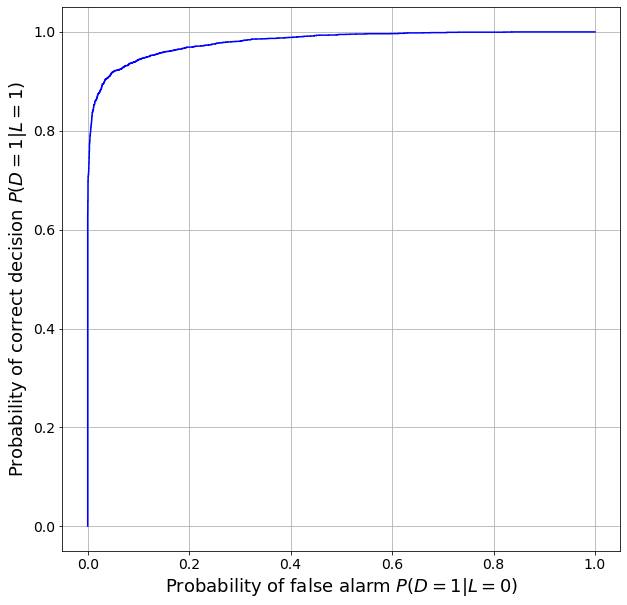

In [136]:
# Expected Risk Minimization Classifier (using true model parameters)
# Using likelihood-ratio as the discriminant score for ERM
class_conditional_likelihoods = np.array([multivariate_normal.pdf(X, mu[l], Sigma[l]) for l in L])
discriminant_score_erm = (class_conditional_likelihoods[1])/(class_conditional_likelihoods[0])

# define a function to generate the ROC curve.
from sys import float_info # Threshold smallest positive floating value

# Generate ROC curve samples
# scores are independent of gamma; labels are known from the data 
def estimate_roc(discriminant_score, label):
    Nlabels = np.array((sum(label == 0), sum(label == 1)))

    sorted_score = sorted(discriminant_score)

    # Use tau values that will account for every possible classification split
    taus = ([sorted_score[0] - float_info.epsilon] + 
             sorted_score +
             [sorted_score[-1] + float_info.epsilon])
   
    # Calculate the decision label for each observation for each gamma
    decisions = [discriminant_score >= t for t in taus]

    # false positives:
    ind10 = [np.argwhere((d==1) & (label==0)) for d in decisions]
    p10 = [len(inds)/Nlabels[0] for inds in ind10]
    # true positives
    ind11 = [np.argwhere((d==1) & (label==1)) for d in decisions]
    p11 = [len(inds)/Nlabels[1] for inds in ind11]
    # false negatives
    ind01 = [np.argwhere((d==0) & (label==1)) for d in decisions]
    p01 = [len(inds)/Nlabels[1] for inds in ind01]
    # true negatives
    ind00 = [np.argwhere((d==0) & (label==0)) for d in decisions]
    p00 = [len(inds)/Nlabels[0] for inds in ind00]

    # ROC has FPR on the x-axis and TPR on the y-axis
    roc = np.array((p10, p11, p01, p00))

    return roc, taus

# Construct the ROC for ERM by changing log(gamma)
roc_erm, gamma_range = estimate_roc(discriminant_score_erm, labels)

fig_roc, ax_roc = plt.subplots(figsize=(10, 10))
ax_roc.plot(roc_erm[0], roc_erm[1], 'b')
ax_roc.set_xlabel(r"Probability of false alarm $P(D=1|L=0)$")
ax_roc.set_ylabel(r"Probability of correct decision $P(D=1|L=1)$")
plt.grid(True)

fig_roc;

3. Determine threshold that achieves min probability of error and plot point on the ROC curve. 

Report estimate of minimum probability of error for this distribution:

P(error; $\gamma$) = P(D = 1 | L = 0 ; $\gamma$) P(L = 0) + P(D=0 | L=1 ; $\gamma$) P(L = 1)

We know from previously that the theoretically optimal value is going to be:

\begin{equation*}
\gamma = \frac{(1 - 0)}{(1 - 0)} \frac{0.65}{0.35} = 1.857
\end{equation*}

Optimal gamma is: 1.6232157063749961
Minimum probabilty of error is: 0.055722676570134196


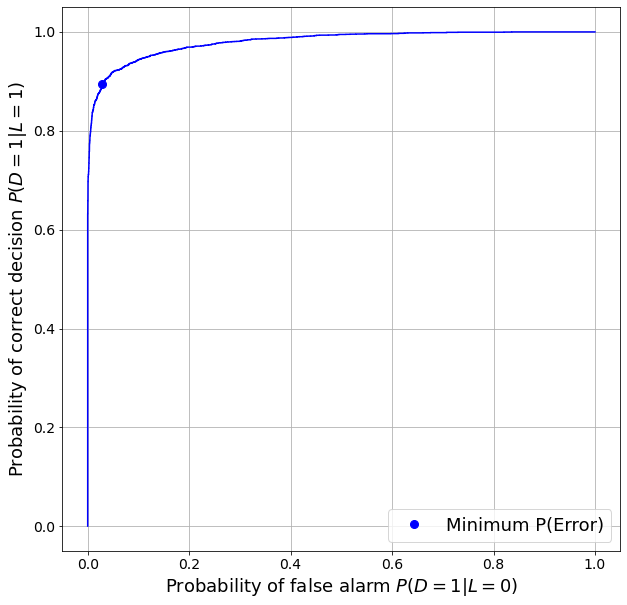

In [137]:
# Probability of error:
# prob of false positive * prob of 0 + prob false negative * prob 1
prob_error_erm = roc_erm[0]*priors[0] + roc_erm[2]*priors[1]
opt_gamma_ix = np.argwhere(prob_error_erm == min(prob_error_erm))
print("Optimal gamma is: {}".format(gamma_range[int(opt_gamma_ix)]))
print("Minimum probabilty of error is: {}".format(prob_error_erm[int(opt_gamma_ix)]))

# plot onto the figure
ax_roc.plot(roc_erm[0][opt_gamma_ix], roc_erm[1][opt_gamma_ix], 'b.', label="Minimum P(Error)", markersize=16)
ax_roc.legend()
fig_roc

### Part B

We redo the problem in part A, but this time, as a Naive Baysean Classifer with the appropriate covariance matrices:

\begin{equation*}
\mathcal{N}(\begin{bmatrix}-1/2\\-1/2\\-1/2\end{bmatrix},\begin{bmatrix}1 & 0 & 0\\0 & 1 & 0\\0 & 0 & 1\end{bmatrix}) 
\quad
\mathcal{N}(\begin{bmatrix}1\\1\\1\end{bmatrix},\begin{bmatrix}1 & 0 & 0\\0 & 1 & 0\\0 & 0 & 1\end{bmatrix})
\quad
\end{equation*}

Now we reimplement the classifier (classification rule doesn't change), plot the ROC and empirical minimum probability of error. 

Optimal gamma is: 1.113580295129418
Minimum probabilty of error Naive Bayes is: 0.06709897760745218


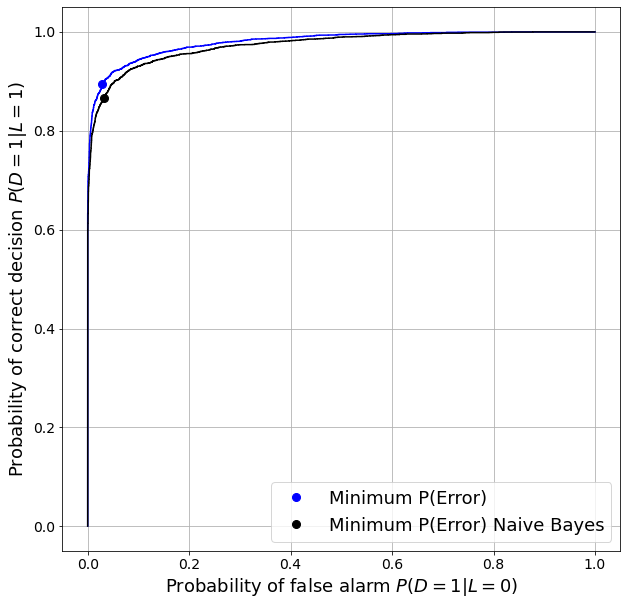

In [138]:
# redefine sigma for the class likelihood calculation:
Sigma_naive = np.array([np.eye(3), np.eye(3)])  # Gaussian distributions covariance matrices

# now calculate with erroneous distribution assumption
class_conditional_likelihoods = np.array([multivariate_normal.pdf(X, mu[l], Sigma_naive[l]) for l in L])
discriminant_score_erm = (class_conditional_likelihoods[1])/(class_conditional_likelihoods[0])

# Construct the ROC for ERM by changing log(gamma)
roc_erm_naive, gamma_range_naive = estimate_roc(discriminant_score_erm, labels)

ax_roc.plot(roc_erm_naive[0], roc_erm_naive[1], 'k')

# Probability of error:
# prob of false positive * prob of 0 + prob false negative * prob 1
prob_error_erm_naive = roc_erm_naive[0]*priors[0] + roc_erm_naive[2]*priors[1]
opt_gamma_ix_naive = np.argwhere(prob_error_erm_naive == min(prob_error_erm_naive))
print("Optimal gamma is: {}".format(gamma_range_naive[int(opt_gamma_ix_naive)]))
print("Minimum probabilty of error Naive Bayes is: {}".format(prob_error_erm_naive[int(opt_gamma_ix_naive)]))

# plot onto the figure
ax_roc.plot(roc_erm_naive[0][opt_gamma_ix_naive], roc_erm_naive[1][opt_gamma_ix_naive], 'k.', label="Minimum P(Error) Naive Bayes", markersize=16)
ax_roc.legend()
fig_roc

Results show that this assumption did negatively impact the curve and minimum error result, which increased by 1.7%. Depending on the context, this is not so bad, especially considering that often you don't have knowledge of the true distribution of the data. 

### Part C

Implement the Fisher LDA classifier using estimated mean vectors and covariance matrices from the data to obtain a classifier $\gamma$ in the following form:

\begin{equation*}
\mathbf{w}^\text{T} \mathbf{x} \begin{matrix} \text{Decide 1} \\ ~~~~>~~~~ \\ ~~~~<~~~~ \\ \text{Decide 0} \end{matrix} \gamma
\end{equation*}

where $\gamma \in (-\inf,\inf)$.

[array([-0.48747353, -0.49583351, -0.50568576]), array([1.0049823 , 0.99903594, 1.01321073])]
[array([[ 0.98066716, -0.48440217,  0.29678927],
       [-0.48440217,  0.9806325 , -0.49757796],
       [ 0.29678927, -0.49757796,  0.97737962]]), array([[ 1.02879001,  0.31771758, -0.21246348],
       [ 0.31771758,  1.02718661,  0.3078813 ],
       [-0.21246348,  0.3078813 ,  0.98290387]])]
Minimum probabilty of error LDA is: 0.06519999999999998


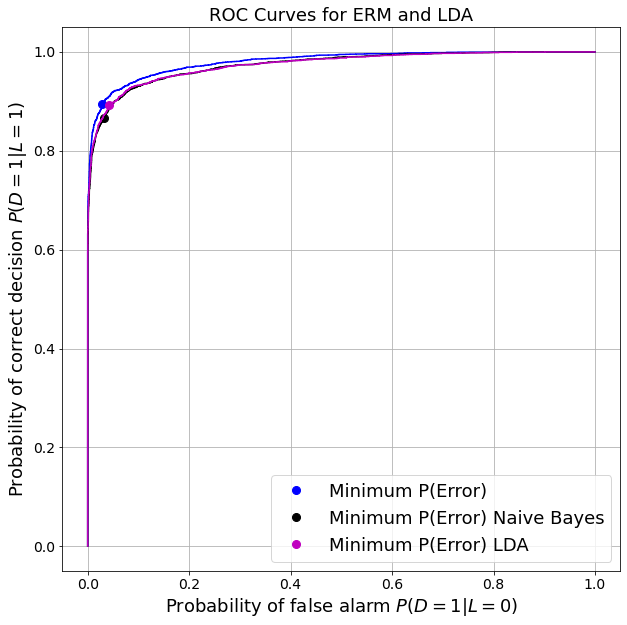

In [139]:

mu_LDA = [np.mean(X[labels == 0, :],axis=0), np.mean(X[labels == 1, :], axis=0)]
Sigma_LDA = [np.cov(X[labels == 0, :], rowvar=False), np.cov(X[labels == 1, :], rowvar=False)]
print(mu_LDA)
print(Sigma_LDA)

# borrow function from Mark, thanks - 
def perform_lda(X, mu, Sigma, C=2):
    """  Fisher's Linear Discriminant Analysis (LDA) on data from two classes (C=2).
   
    Args:
        X: Real-valued matrix of samples with shape [N, n], N for sample count and n for dimensionality.
        mu: Mean vector [C, n].
        Sigma: Covariance matrices [C, n, n].

    Returns:
        w: Fisher's LDA project vector, shape [n, 1].
        z: Scalar LDA projections of input samples, shape [N, 1].
    """
    
    mu = np.array([mu[i].reshape(-1, 1) for i in range(C)])
    cov = np.array([Sigma[i].T for i in range(C)])

    # Determine between class and within class scatter matrix
    # Contintue assumption that class priors are equal:
    Sb = (mu[1] - mu[0]).dot((mu[1] - mu[0]).T)
    Sw = cov[0] + cov[1]

    # Regular eigenvector problem for matrix Sw^-1 Sb
    lambdas, U = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    # Get the indices from sorting lambdas in order of increasing value, with ::-1 slicing to then reverse order
    idx = lambdas.argsort()[::-1]

    # Extract corresponding sorted eigenvectors
    U = U[:, idx]

    # First eigenvector is now associated with the maximum eigenvalue, mean it is our LDA solution weight vector
    w = U[:, 0]

    # Scalar LDA projections in matrix form
    z = X.dot(w)

    return w, z

# Classifier
w_LDA, discriminant_score_lda = perform_lda(X, mu_LDA, Sigma_LDA)

# Estimate the ROC curve for this LDA classifier
roc_lda, tau_lda = estimate_roc(discriminant_score_lda, labels)

# ROC returns FPR vs TPR, but prob error needs FNR so take 1-TPR
prob_error_lda = np.array((roc_lda[0,:], 1 - roc_lda[1,:])).T.dot(Nl.T / N)

# Min prob error
min_prob_error_lda = np.min(prob_error_lda)
min_ind = np.argmin(prob_error_lda)
print("Minimum probabilty of error LDA is: {}".format(min_prob_error_lda))


# Display the estimated ROC curve for LDA and indicate the operating points
# with smallest empirical error probability estimates (could be multiple)
ax_roc.plot(roc_lda[0], roc_lda[1], 'm')
ax_roc.plot(roc_lda[0, min_ind], roc_lda[1, min_ind], 'm.', label="Minimum P(Error) LDA", markersize=16)
ax_roc.set_title("ROC Curves for ERM and LDA")
ax_roc.legend()

fig_roc


Comment on the minimum probability of error estimates obtained for each classifier:

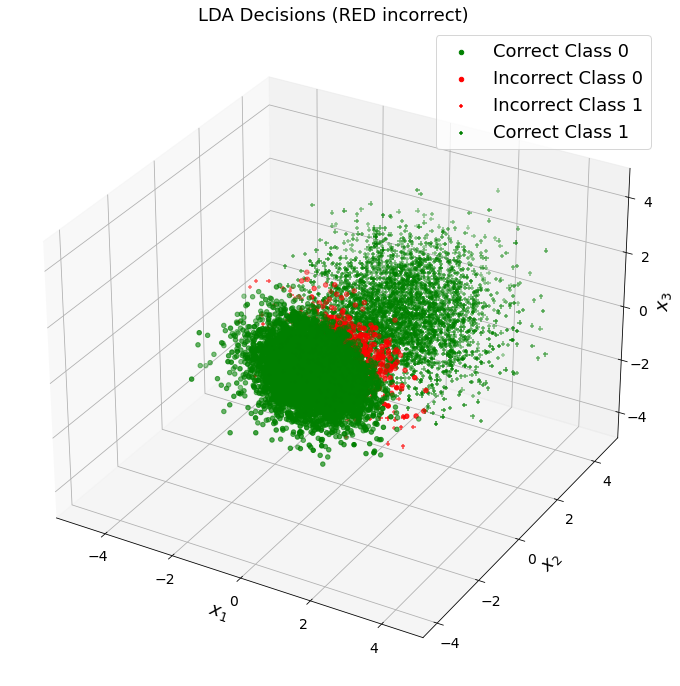

Smallest P(error) for ERM = 0.055722676570134196
Smallest P(error) for ERM Naive Bayes = 0.06709897760745218
Smallest P(error) for LDA = 0.06519999999999998


In [140]:
# Use min-error threshold
decisions_lda = discriminant_score_lda >= tau_lda[min_ind]

# Get indices and probability estimates of the four decision scenarios:
# (true negative, false positive, false negative, true positive)

# True Negative Probability
ind_00_lda = np.argwhere((decisions_lda==0) & (labels==0))
p_00_lda = len(ind_00_lda) / Nl[0]
# False Positive Probability
ind_10_lda = np.argwhere((decisions_lda==1) & (labels==0))
p_10_lda = len(ind_10_lda) / Nl[0]
# False Negative Probability
ind_01_lda = np.argwhere((decisions_lda==0) & (labels==1))
p_01_lda = len(ind_01_lda) / Nl[1]
# True Positive Probability
ind_11_lda = np.argwhere((decisions_lda==1) & (labels==1))
p_11_lda = len(ind_11_lda) / Nl[1]

# Display LDA decisions
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

# class 0 circle, class 1 +, correct green, incorrect red
ax.scatter(X[ind_00_lda, 0], X[ind_00_lda, 1], X[ind_00_lda, 2], c='g', marker='o', label="Correct Class 0")
ax.scatter(X[ind_10_lda, 0], X[ind_10_lda, 1], X[ind_10_lda, 2], c='r', marker='o', label="Incorrect Class 0")
ax.scatter(X[ind_01_lda, 0], X[ind_01_lda, 1], X[ind_01_lda, 2], c='r', marker='+', label="Incorrect Class 1")
ax.scatter(X[ind_11_lda, 0], X[ind_11_lda, 1], X[ind_11_lda, 2], c='g', marker='+', label="Correct Class 1")

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
ax.set_zlabel(r"$x_3$")
plt.title("LDA Decisions (RED incorrect)")
plt.tight_layout()
plt.show()

print("Smallest P(error) for ERM = {}".format(prob_error_erm[int(opt_gamma_ix)]))
print("Smallest P(error) for ERM Naive Bayes = {}".format(prob_error_erm_naive[int(opt_gamma_ix_naive)]))
print("Smallest P(error) for LDA = {}".format(min_prob_error_lda))

Since the MAP classifier is designed to minimize probability error (when implemented with true class conditional likelihoods and class priors), we expected its error probability to be lower than that of all other classifiers, including Fisher's LDA. The numerical experiment is consistent with this theoretical result. 

We also note that since the dataset is random, occasionally (less frequently for larger N) the empirical error probability estimate of LDA may by chance be lower than that of the MAP classifier; those are due to random sample variations in error probability estimates using samples.

Performance of Naive Bayes and LDA quite similar, although LDA performed better. Not sure why these would be similar?